In [29]:
# import dask.config as dc
import dask.array as da
import numpy as np
import rioxarray
import xarray as xr
import glob
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster
import pandas as pd
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt

# SSM data: from NetCDF to Zarr

The Leaf Area Index (LAI) dataset is provided as chunked NetCDF4/HDF5 data. We reproject the spatial extend to match the ERA5 land dataset using rioxarray, which, unfortunately does not support Dask.

## Input variables

In [30]:
year = 2015

In [31]:
ROOT_DIR = '/gpfs/work2/0/ttse0619'
SSM_DIR = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/ssm/'
)
OUT_DIR = (
    f'{ROOT_DIR}/qianqian/global_data_Qianqian/'
    f'1input_data/{year}global/ssm'
)

In [32]:
ERA5_PATH = (
    f'{ROOT_DIR}/francesco/Projects/EcoExtreML/Data/'
    f'1input_data/{year}global/era5land/era5land.zarr'
)

## Converting the dataset

We start by loading the ERA5-land Zarr dataset, which we will use as the target for reprojection: 

In [33]:
ds = xr.open_zarr(ERA5_PATH)

In [34]:
ds = ds.rio.write_crs('WGS84')
target0 = ds['sp'].isel(time=0, drop=True)

select Europe area

In [35]:
import geopandas as gpd
from shapely.geometry import box

shapefile_path = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/Emulator/input_data/EuropeBoundary.shp"
gdf = gpd.read_file(shapefile_path)
bbox = gdf.total_bounds
bbox

array([-31.28903052,  34.93055094,  68.93136141,  81.85192337])

In [36]:
target1 = target0.sel(
    latitude=slice(bbox[3], bbox[1]),  
    longitude=slice(0, (bbox[2]+360)%360)  
)
target2 = target0.sel(
    latitude=slice(bbox[3], bbox[1]),  
    longitude=slice((bbox[0]+360)%360, 360)  
)
target = xr.concat([target1, target2], dim='longitude')
target = target.sortby('longitude')

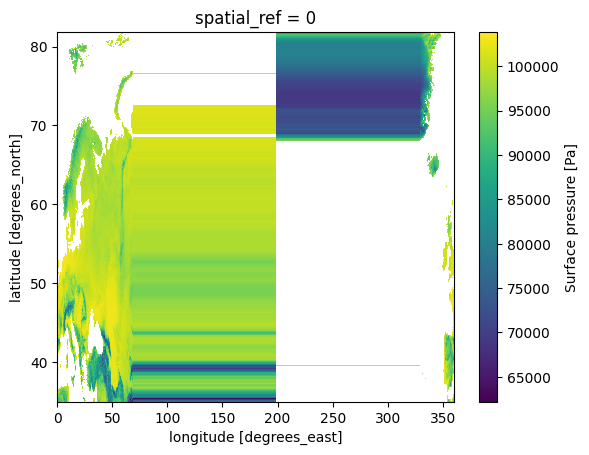

In [37]:
target.plot() # why it looks so weird? but the reprojected ssm seems okay

We now open the SSM geotiff files. NOTE: we do not set chunks in the spatial dimension because we need to load all values anyway to perform the reprojection. 

In [38]:
ssm_paths = sorted(
    glob.glob(f'{SSM_DIR}/*2015*Europe*Europe*.tif')
)

In [39]:
ssm = xr.open_dataset(ssm_paths[0])
ssm = ssm['band_data']
# ssm = ssm.sel(x=slice(20,25), y=slice(65, 60))

In [40]:
ssm

<xarray.DataArray 'band_data' (band: 365, y: 470, x: 1003)>
[172064650 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * x            (x) float64 -31.25 -31.15 -31.05 -30.95 ... 68.75 68.85 68.95
  * y            (y) float64 81.85 81.75 81.65 81.55 ... 35.25 35.15 35.05 34.95
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area

We fix the longitude ordering and make sure the CRS is in place:

In [41]:
ssm = ssm.rio.write_crs('WGS84')
ssm = ssm.rename(
    x='longitude',
    y='latitude',
)
ssm = ssm.assign_coords(
    longitude=(ssm.longitude + 360) % 360,
    latitude=ssm.latitude
)#.sortby('longitude')
# roll array to reorder coordinates 
nroll = (ssm.longitude.values >= 180 ).sum()
ssm = ssm.roll(longitude=-nroll, roll_coords=True)

We change band to time, and reproject!

In [43]:
ssm['band'] = pd.to_datetime(ssm.band-1, unit='D', origin=str(ssm_paths[0].split('/')[-1][2:6]))
ssm = ssm.rename({'band':'time'})
ssm = ssm[0:2,:] # test for short periods

In [44]:
ssm.rio.write_nodata(np.nan, inplace=True)
ssm = ssm.rio.write_crs('EPSG:4326')
target = target.rio.write_crs('EPSG:4326')
ssm.rio.write_nodata(ssm.rio.nodata, inplace=True)
ssm_reprojected = ssm.rio.reproject_match(target, resampling=Resampling.average, nodata=np.nan) #
ssm_reprojected = ssm_reprojected.rename(
    x='longitude',
    y='latitude',
)
ssm_reprojected.isnull().sum()

<xarray.DataArray 'band_data' ()>
array(656290)
Coordinates:
    spatial_ref  int64 0

In [45]:
ssm_reprojected.isnull().sum()

<xarray.DataArray 'band_data' ()>
array(656290)
Coordinates:
    spatial_ref  int64 0

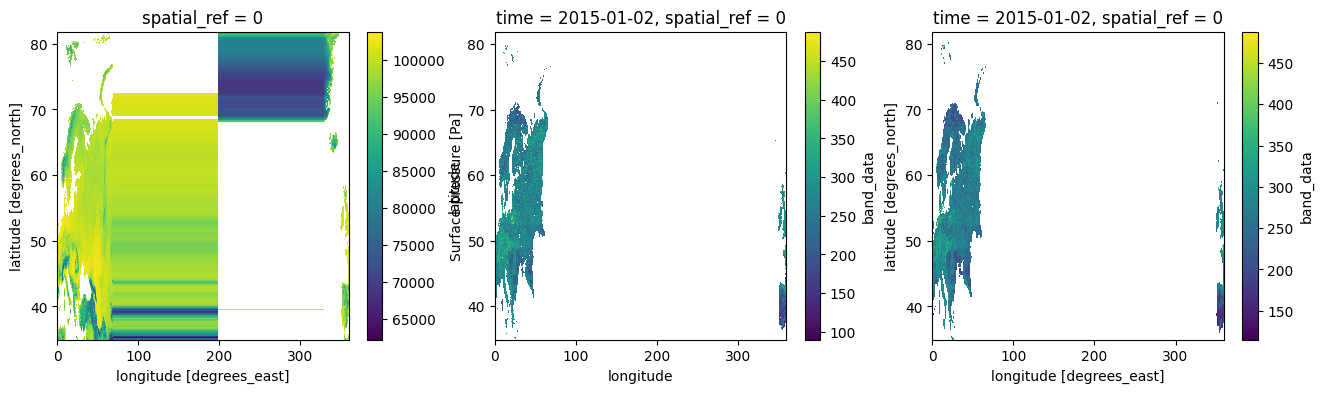

In [46]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

target.plot(ax=axes[0])
ssm[-1,::].plot(ax=axes[1])
ssm_reprojected[-1,::].plot(ax=axes[2])
plt.draw()

We rechunk and save it as Zarr:

In [26]:
ssm_reprojected = ssm_reprojected.chunk(
    time=-1, 
    longitude=250, 
    latitude=250
)
ssm_reprojected = ssm_reprojected.to_dataset(name='SSM')

In [27]:
%%time
zarr_path = f'{OUT_DIR}/ssm.zarr'
ssm_reprojected.to_zarr(zarr_path, mode='w')

CPU times: user 22.6 ms, sys: 9.6 ms, total: 32.2 ms
Wall time: 174 ms


When done with the conversion we switch off the cluster to release resources:

In [89]:
!du -h $zarr_path

2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr/spatial_ref
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr/longitude
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr/latitude
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr/time
1.5K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr/SSM
11K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2015global/ssm/ssm.zarr
